<a href="https://colab.research.google.com/github/sruthikoyya/SummerIntership_NITR/blob/main/CBAM_UNet_Pytorch_NITR_Human_at_EncoderDecoder_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torchmetrics torchvision

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import torchvision.transforms.functional as TF
import numpy as np
import os
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Directories
image_dir = "/content/drive/MyDrive/Human-Segmentation-Dataset-master/Training_Images"
mask_dir = "/content/drive/MyDrive/Human-Segmentation-Dataset-master/Ground_Truth"
image_size = 128

In [ ]:
class CustomSegmentationDataset():
    def __init__(self, image_dir, mask_dir, image_size=128):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_size = image_size

        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

        # Load only valid image files, skip .DS_Store or others
        self.image_filenames = [
            f for f in os.listdir(self.image_dir)
            if not f.startswith('.') and f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

    def __len__(self):
        return len(self.images)



    def __getitem__(self, idx):
        # Paths
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        # Load image and mask
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Grayscale

        # Resize
        image = TF.resize(image, (self.image_size, self.image_size))
        mask = TF.resize(mask, (self.image_size, self.image_size), interpolation=Image.NEAREST)

        # Convert to tensors
        image = TF.to_tensor(image)  # (3, H, W)
        mask = torch.from_numpy(np.array(mask)).long()  # (H, W)

        # Binarize mask: convert any non-zero pixel to 1
        mask = (mask > 0).float().unsqueeze(0)  # (1, H, W)

        return image, mask

In [ ]:
# Create dataset
dataset = CustomSegmentationDataset(image_dir=image_dir, mask_dir=mask_dir, image_size=image_size)

In [ ]:

# Split dataset: 80% train, 10% val, 10% test
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size =total_size - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)

In [ ]:
print(total_size,train_size,val_size,test_size)

290 203 58 29


In [ ]:
images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)

torch.Size([8, 3, 128, 128])
torch.Size([8, 1, 128, 128])


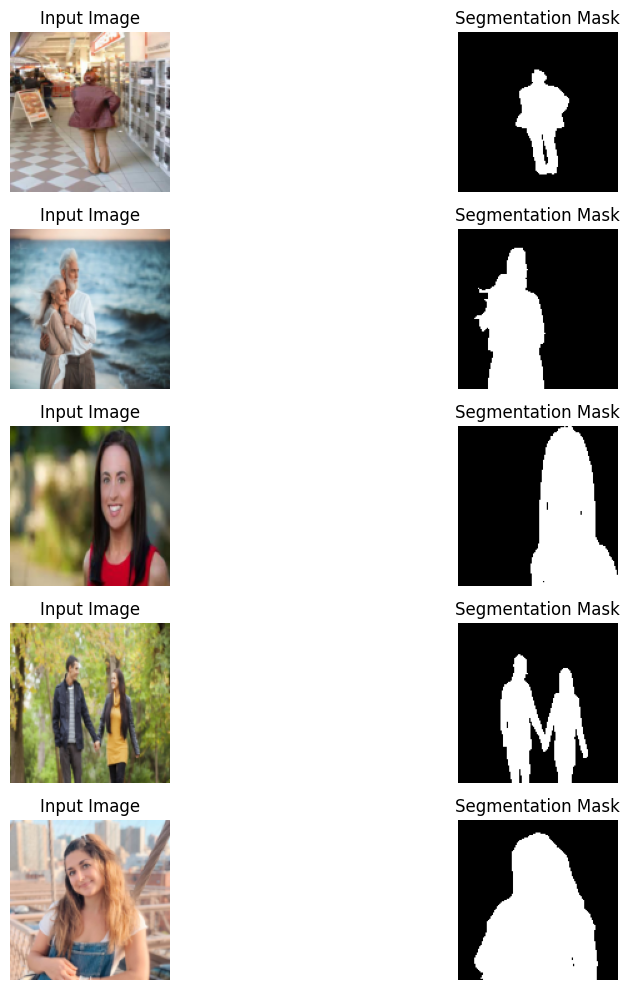

In [ ]:
import matplotlib.pyplot as plt

def show_batch_from_loader(loader, num_samples=5):
    images, masks = next(iter(loader))  # Get one batch from DataLoader
    images = images[:num_samples]
    masks = masks[:num_samples]

    plt.figure(figsize=(12, num_samples * 2))

    for i in range(num_samples):
        image = images[i].permute(1, 2, 0).numpy()  # Convert [C,H,W] → [H,W,C]
        mask = masks[i].squeeze().numpy()           # Convert [1,H,W] → [H,W]

        # Plot image
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(image)
        plt.title("Input Image")
        plt.axis("off")

        # Plot mask
        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(mask, cmap="gray")
        plt.title("Segmentation Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Call the function
show_batch_from_loader(train_loader)


In [ ]:
# Walk through all subdirectories and delete .DS_Store files
for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file == '.DS_Store':
            os.remove(os.path.join(root, file))

In [ ]:
# Walk through all subdirectories and delete .DS_Store files
for root, dirs, files in os.walk(mask_dir):
    for file in files:
        if file == '.DS_Store':
            os.remove(os.path.join(root, file))

In [ ]:

# CBAM Module (Channel + Spatial Attention)
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, reduction=16,dropout=0.1):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Conv2d(in_planes // reduction, in_planes, 1, bias=False)
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        x_out = self.conv(x_cat)
        return self.sigmoid(x_out)

class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(channels, reduction)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x


In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super(EncoderBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )
        self.cbam = CBAM(out_channels)  # Attention added here
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.conv(x)
        x = self.cbam(x)  # Apply CBAM
        p = self.pool(x)
        return x, p


In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels + out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )
        self.cbam = CBAM(out_channels)  # Attention added here

    def forward(self, x, skip):
        x = self.up(x)
        if x.size() != skip.size():
            x = F.interpolate(x, size=skip.shape[2:])
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        x = self.cbam(x)  # Apply CBAM
        return x

In [ ]:
class AttentionUNet(nn.Module):
    def __init__(self, img_ch=3, output_ch=1, dropout=0.1):
        super().__init__()
        # Encoder
        self.enc1 = EncoderBlock(img_ch, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            CBAM(512)  # CBAM added to bottleneck
        )

        # Removed CBAMs from skip connections
        self.dec4 = DecoderBlock(512, 256)
        self.dec3 = DecoderBlock(256, 128)
        self.dec2 = DecoderBlock(128, 64)
        self.dec1 = DecoderBlock(64, 64)

        self.final = nn.Conv2d(64, output_ch, kernel_size=1)

    def forward(self, x):
        x1, p1 = self.enc1(x)
        x2, p2 = self.enc2(p1)
        x3, p3 = self.enc3(p2)
        x4, p4 = self.enc4(p3)

        bn = self.bottleneck(p4)

        d4 = self.dec4(bn, x4)
        d3 = self.dec3(d4, x3)
        d2 = self.dec2(d3, x2)
        d1 = self.dec1(d2, x1)

        return torch.sigmoid(self.final(d1))

In [ ]:
pip install torchinfo

In [ ]:
from torchinfo import summary

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = preds.contiguous()
        targets = targets.contiguous()

        intersection = (preds * targets).sum(dim=(2,3))
        dice = (2. * intersection + self.smooth) / (preds.sum(dim=(2,3)) + targets.sum(dim=(2,3)) + self.smooth)

        return 1 - dice.mean()

In [ ]:
bce = nn.BCELoss()
dice = DiceLoss()

def combined_loss(preds, targets):
    return bce(preds, targets) + dice(preds, targets)



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model =AttentionUNet(3,1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#criterion = nn.BCELoss()  # Binary segmentation uses Binary Cross-Entropy
criterion = combined_loss


In [ ]:
summary(model, input_size=(1, 3, 256, 256), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #
AttentionUNet                                 [1, 3, 256, 256]          [1, 1, 256, 256]          --
├─EncoderBlock: 1-1                           [1, 3, 256, 256]          [1, 64, 256, 256]         --
│    └─Sequential: 2-1                        [1, 3, 256, 256]          [1, 64, 256, 256]         --
│    │    └─Conv2d: 3-1                       [1, 3, 256, 256]          [1, 64, 256, 256]         1,792
│    │    └─BatchNorm2d: 3-2                  [1, 64, 256, 256]         [1, 64, 256, 256]         128
│    │    └─ReLU: 3-3                         [1, 64, 256, 256]         [1, 64, 256, 256]         --
│    │    └─Dropout: 3-4                      [1, 64, 256, 256]         [1, 64, 256, 256]         --
│    │    └─Conv2d: 3-5                       [1, 64, 256, 256]         [1, 64, 256, 256]         36,928
│    │    └─BatchNorm2d: 3-6                  [1, 64, 256, 256]         [1, 64

In [ ]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    correct_pixels = 0
    total_pixels = 0

    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        preds = model(images)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds_binary = (preds > 0.5).float()
        correct_pixels += (preds_binary == masks).sum().item()
        total_pixels += torch.numel(preds)

    accuracy = correct_pixels / total_pixels
    return epoch_loss / len(dataloader), accuracy

def validate(model, dataloader, criterion):
    model.eval()
    val_loss = 0
    correct_pixels = 0
    total_pixels = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            preds = model(images)
            loss = criterion(preds, masks)
            val_loss += loss.item()

            preds_binary = (preds > 0.5).float()
            correct_pixels += (preds_binary == masks).sum().item()
            total_pixels += torch.numel(preds)

    accuracy = correct_pixels / total_pixels
    return val_loss / len(dataloader), accuracy


In [ ]:
num_epochs = 70
patience = 7 # Number of epochs to wait before stopping
best_val_loss = float('inf')
early_stop_counter = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        best_model_state = model.state_dict()  # Save best model
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            model.load_state_dict(best_model_state)  # Restore best model
            break


Epoch 1/70 | Train Loss: 1.3100, Accuracy: 0.6879 | Val Loss: 1.3652, Accuracy: 0.7241
Epoch 2/70 | Train Loss: 1.1975, Accuracy: 0.7710 | Val Loss: 1.2560, Accuracy: 0.7834
Epoch 3/70 | Train Loss: 1.1029, Accuracy: 0.8220 | Val Loss: 1.1268, Accuracy: 0.8191
Epoch 4/70 | Train Loss: 1.0312, Accuracy: 0.8132 | Val Loss: 0.9939, Accuracy: 0.8781
Epoch 5/70 | Train Loss: 0.9681, Accuracy: 0.8158 | Val Loss: 0.9541, Accuracy: 0.8476
Epoch 6/70 | Train Loss: 0.8938, Accuracy: 0.8178 | Val Loss: 0.8888, Accuracy: 0.8358
Epoch 7/70 | Train Loss: 0.8437, Accuracy: 0.8417 | Val Loss: 0.8192, Accuracy: 0.8760
Epoch 8/70 | Train Loss: 0.7839, Accuracy: 0.8662 | Val Loss: 0.8150, Accuracy: 0.8767
Epoch 9/70 | Train Loss: 0.7518, Accuracy: 0.8768 | Val Loss: 0.7913, Accuracy: 0.8826
Epoch 10/70 | Train Loss: 0.6910, Accuracy: 0.8972 | Val Loss: 0.8229, Accuracy: 0.8677
Epoch 11/70 | Train Loss: 0.6704, Accuracy: 0.8942 | Val Loss: 0.7044, Accuracy: 0.8915
Epoch 12/70 | Train Loss: 0.6481, Accurac

In [ ]:
from sklearn.metrics import accuracy_score, jaccard_score, f1_score, precision_score, recall_score

In [ ]:
def compute_metrics(model, dataloader, device, alpha=0.5, beta=0.5):
    model.eval()
    all_preds = []
    all_targets = []

    bce_loss_fn = nn.BCELoss()
    bce_losses = []
    dice_losses = []
    total_losses = []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            preds = model(images)
            preds_bin = (preds > 0.5).float()

            # Store predictions and targets
            all_preds.extend(preds_bin.cpu().numpy().reshape(-1))
            all_targets.extend(masks.cpu().numpy().reshape(-1))

            # BCE Loss
            bce = bce_loss_fn(preds, masks)
            bce_losses.append(bce.item())

            # Dice Loss and Dice Coefficient
            smooth = 1e-7
            intersection = (preds_bin * masks).sum(dim=(1, 2, 3))
            union = preds_bin.sum(dim=(1, 2, 3)) + masks.sum(dim=(1, 2, 3))
            dice_coeff = (2. * intersection + smooth) / (union + smooth)
            dice_loss = 1 - dice_coeff.mean()
            dice_losses.append(dice_loss.item())

            # Combined Loss
            total_loss = alpha * bce + beta * dice_loss
            total_losses.append(total_loss.item())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Compute metrics
    acc = accuracy_score(all_targets, all_preds)
    iou = jaccard_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    avg_bce = np.mean(bce_losses)
    avg_dice_loss = np.mean(dice_losses)
    avg_total_loss = np.mean(total_losses)
    avg_dice_coeff = 1 - avg_dice_loss

    # Print results
    print(f"\nEvaluation Metrics on Validation Set:")
    print(f"Accuracy               : {acc:.4f}")
    print(f"IoU (Jaccard)          : {iou:.4f}")
    print(f"F1 Score               : {f1:.4f}")
    print(f"Dice Coefficient       : {avg_dice_coeff:.4f}")
    print(f"Dice Loss              : {avg_dice_loss:.4f}")
    print(f"Precision              : {precision:.4f}")
    print(f"Recall                 : {recall:.4f}")
    print(f"Binary Cross Entropy   : {avg_bce:.4f}")
    print(f"Combined BCE + Dice    : {avg_total_loss:.4f}")

In [ ]:
compute_metrics(model, val_loader,device)


Evaluation Metrics on Validation Set:
Accuracy               : 0.9183
IoU (Jaccard)          : 0.7221
F1 Score               : 0.8386
Dice Coefficient       : 0.8347
Dice Loss              : 0.1653
Precision              : 0.8970
Recall                 : 0.7874
Binary Cross Entropy   : 0.2896
Combined BCE + Dice    : 0.2274


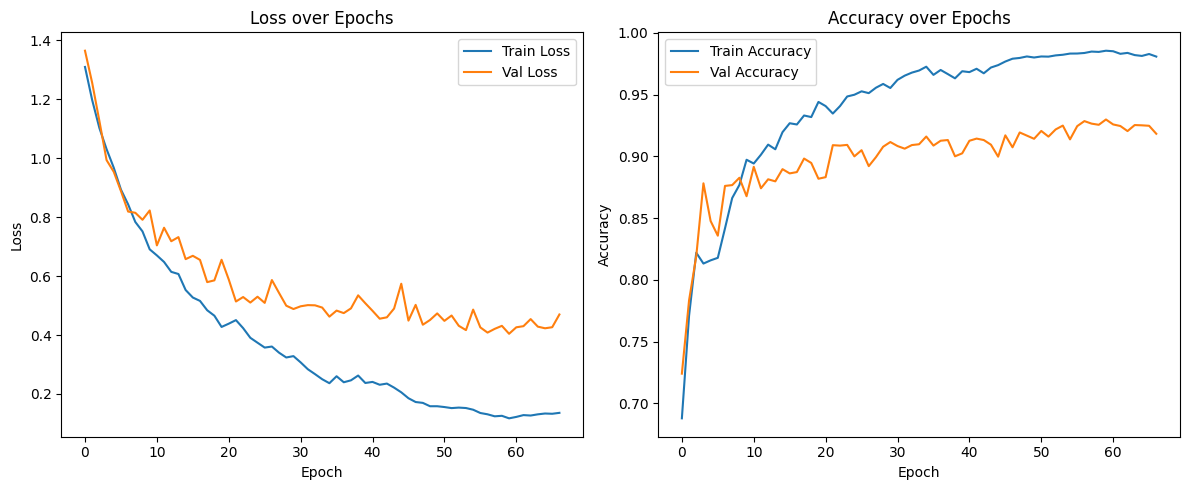

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def show_predictions(model, dataloader, num_samples=3):
    model.eval()
    count = 0

    for images, masks in dataloader:
        images = images.to(device)
        with torch.no_grad():
            preds = model(images)
            preds = (preds > 0.5).float()

        for i in range(images.shape[0]):
            if count >= num_samples:
                return

            image = images[i].cpu().permute(1, 2, 0).numpy()
            mask = masks[i].cpu().squeeze().numpy()
            pred = preds[i].cpu().squeeze().numpy()

            plt.figure(figsize=(12, 3))
            plt.subplot(1, 3, 1)
            plt.imshow(image)
            plt.title("Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(mask, cmap="gray")
            plt.title("Ground Truth")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(pred, cmap="gray")
            plt.title("Prediction")
            plt.axis("off")

            plt.show()
            count += 1

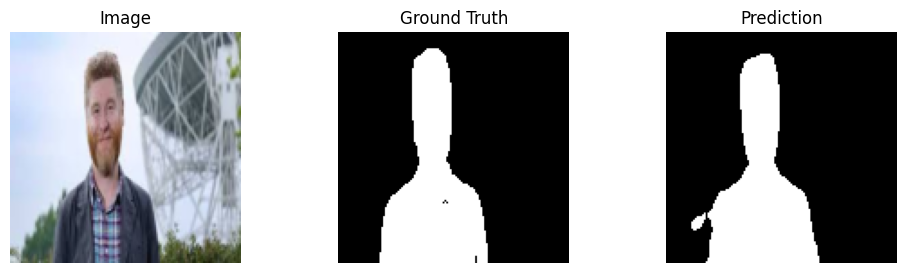

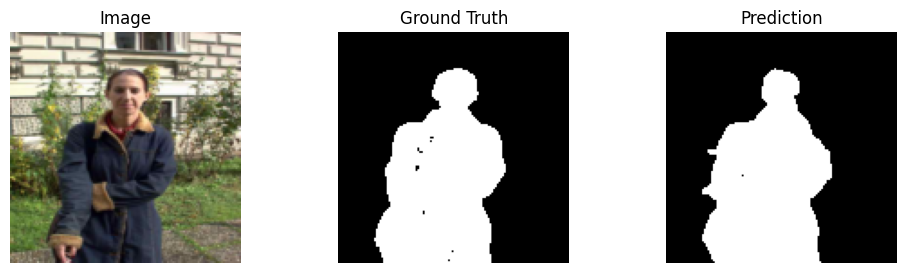

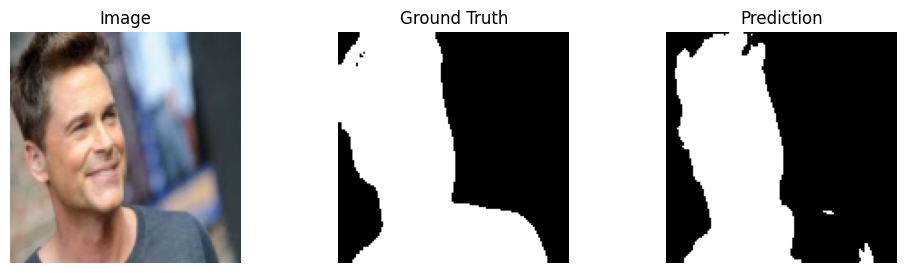

In [ ]:
show_predictions(model, val_loader)

In [ ]:
def evaluate_on_test(model, test_loader, device, alpha=0.5, beta=0.5):
    model.eval()
    all_preds = []
    all_targets = []
    dice_losses = []
    bce_losses = []
    total_losses = []

    bce_loss_fn = nn.BCELoss()

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds_bin = (outputs > 0.5).float()

            # Store predictions and targets
            all_preds.extend(preds_bin.cpu().numpy().reshape(-1))
            all_targets.extend(masks.cpu().numpy().reshape(-1))

            # BCE Loss
            bce = bce_loss_fn(outputs, masks)
            bce_losses.append(bce.item())

            # Dice Loss
            smooth = 1e-7
            intersection = (preds_bin * masks).sum(dim=(1, 2, 3))
            union = preds_bin.sum(dim=(1, 2, 3)) + masks.sum(dim=(1, 2, 3))
            dice_coeff = (2. * intersection + smooth) / (union + smooth)
            dice_loss = 1 - dice_coeff.mean()
            dice_losses.append(dice_loss.item())

            # Combined Loss
            total_loss = alpha * bce + beta * dice_loss
            total_losses.append(total_loss.item())

    # Convert to NumPy arrays
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Compute evaluation metrics
    acc = accuracy_score(all_targets, all_preds)
    iou = jaccard_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    avg_bce = np.mean(bce_losses)
    avg_dice_loss = np.mean(dice_losses)
    avg_total_loss = np.mean(total_losses)
    avg_dice_coeff = 1 - avg_dice_loss

    # Print results
    print("\nTest Set Evaluation:")
    print(f"Accuracy            : {acc:.4f}")
    print(f"IoU                 : {iou:.4f}")
    print(f"F1 Score            : {f1:.4f}")
    print(f"Precision           : {precision:.4f}")
    print(f"Recall              : {recall:.4f}")
    print(f"Dice Coefficient    : {avg_dice_coeff:.4f}")
    print(f"Dice Loss           : {avg_dice_loss:.4f}")
    print(f"Binary Cross Entropy: {avg_bce:.4f}")
    print(f"Combined BCE + Dice : {avg_total_loss:.4f}")

In [ ]:
evaluate_on_test(model, test_loader,device)


Test Set Evaluation:
Accuracy            : 0.9140
IoU                 : 0.7293
F1 Score            : 0.8435
Precision           : 0.9379
Recall              : 0.7663
Dice Coefficient    : 0.8537
Dice Loss           : 0.1463
Binary Cross Entropy: 0.3457
Combined BCE + Dice : 0.2460
